#Guía Beamforming Adaptativo

Integrantes:
- Ian Díaz
- Martín Rodriguez Turco
- Agustin Galdeman

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1
En Python, modelar la respuesta de un arreglo de M sensores espaciados por la
distancia d a una señal de banda base compleja x(n) modulada a una frecuencia de
longitud de onda λc y proveniente desde la dirección φs. Asumir que x(n) se presenta en
el primer sensor del arreglo sin retardo. La función debe cumplir con el prototipo:
 def model_signal(M, d, x, lambda_c, phi_s) 

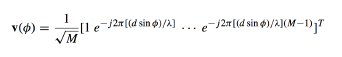

In [2]:
def generate_v(M, d, lambda_c, phi_s):
  """
  Genera vector de respuesta al arreglo
  """
  m = np.arange(0,M)
  v = np.power(np.e, -2j*np.pi*m*( d*np.sin(np.deg2rad(phi_s)) / lambda_c))
  return v / np.sqrt(M)

def model(M,d,x,lambda_c, phi_s):
  """
  Modelamos las señales inidentes sobre cada uno de los sensores.

  Parameters
  ----------
  M: cantidad de sensores
  d: espaciamiento entre sensores
  lambda_c: longitud de onda de la portadora
  phi_s: angulo de incidencia
  """
  x = np.array(x)
  v = generate_v(M, d, lambda_c, phi_s)
  response = np.array([x*phase_shift for phase_shift in v])

  return v, response

2 En Python, modelar el ruido térmico de energía σ2 de un arreglo de M sensores para N
instantes temporales. La función debe cumplir con el prototipo:

In [3]:
def model_noise(M, N, sigma_2):
  noise = np.random.rand(M, N)*sigma_2
  return noise

3. Aprovechando las funciones del punto 1 y 2, estimar el espectro de potencia espacial
de una señal de banda base compleja compuesta por una señal x1(n) de ruido blanco
gaussiano de media cero proveniente desde φs1 = -45° y energía σ2x1 = 1, y una señal
x2(n) de ruido blanco gaussiano de media cero proveniente desde φs2 = -65° y energía
σ2x2 = 0.1. La señal es electromagnética, se transmite por aire y es modulada a Fc = 3
GHz; el ruido de los sensores es σ2n = 0.005. Para un taper con ventana rectangular y
un taper con ventana de Hamming:
a. Determinar la cantidad de sensores M y el espaciamiento d óptimo.
b. Determinar la cantidad de instantes temporales N óptima.
c. Determinar la cantidad de puntos óptima para el barrido de φ.
d. Representar el espectro de potencia espacial en función de φ.
Justificar todas las decisiones. ¿Cómo se comparan las estimaciones de ambos
tapers? Sacar conclusiones.

In [4]:
c =  3E8 #m/s velocidad en el aire
Fc = 3E+9 
lambda_signals = c / Fc
print(f"Longitud de onda lambda de la señal {np.round(lambda_signals,2)} metros")
d_max = lambda_signals/2
print(f"La distancia maxima entre sensores es {d_max} metros")

Longitud de onda lambda de la señal 0.1 metros
La distancia maxima entre sensores es 0.05 metros


Elección de la cantidad optima de sensores

$$\Delta_{3_{dB}} \approx \frac{\lambda}{L}$$

$$\Delta_{3_{dB}} \approx \frac{\lambda}{d \cdot M}$$

$$deg2rad(1°) \approx \frac{0.1m}{0.05 \cdot M}$$
$$ 0.0174 \approx \frac{0.1m}{0.05 \cdot M}$$

$$M \approx 115$$



In [5]:
#Generamos las señales
M = 115
N = 1000 #Empiricamente obtuvimos buenos resultados con N = 1000
sigma_2_1 = 1 
signal_1 = model_noise(1, N, sigma_2_1).flatten()

sigma_2_2 = 0.1
signal_2 = model_noise(1, N, sigma_2_2).flatten()

#Generamos el ruido aditivo de los sensores
sigma_2_sensor = 0.005
sensors_noise = model_noise(M, N, sigma_2_sensor)

#Modelamos la recepción de las señales
d = 0.04 #metros #Elegimos poner 0.04 para ganar algo de redundancia
v_m45 , model_1 = model(M, d, signal_1, lambda_signals, -45)
v_m65, model_2 = model(M, d, signal_2, lambda_signals, -65)

#Modelamos las señales que se reciben en los sensores
x_n = (model_1 + model_2)*np.sqrt(M) + sensors_noise

# Calculo del espectro de potencia espacial

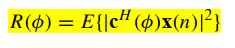

In [6]:
def generate_c(angle, M, d ,lambda_c):
  m = np.arange(0, M)
  c = np.power(np.e, -2j*np.pi*m*( d*np.sin(np.deg2rad(angle)) / lambda_c))
  return c/np.sqrt(M)

In [7]:
def compute_spatial_spectrum(x_n, c = None, window=False):
  power_at_angle = []
  angles = np.linspace(-90, 90, 1000)
  for angle in angles:
    c = generate_c(angle, x_n.shape[0],d,lambda_signals)
    if window == False:
      power_at_angle.append(np.mean(np.power(np.abs(np.dot(np.conjugate(c), x_n)),2)))
    elif window == True:
      power_at_angle.append(np.mean(np.power(np.abs(np.dot(np.conjugate(c)*np.hamming(len(c))/np.max(np.hamming(len(c))), x_n)),2)))
  return angles, np.array(power_at_angle)

## Estimación del espectro de potencia espacial **sin ventaneo**

In [8]:
angles, power_at_angle = compute_spatial_spectrum(x_n)
spectral_power_db = 10*np.log10(power_at_angle / M);

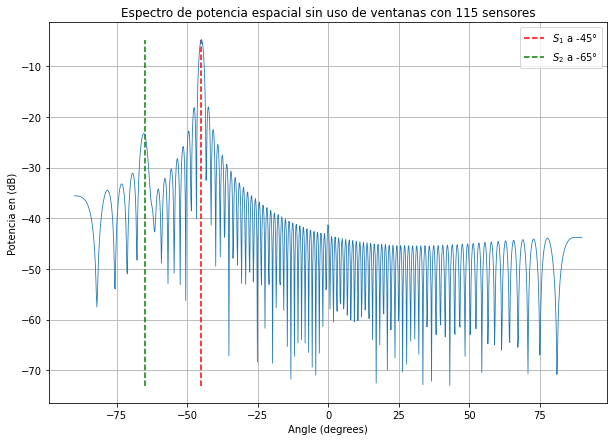

In [9]:
angles, power_at_angle = compute_spatial_spectrum(x_n)
spectral_power_db = 10*np.log10(power_at_angle / M);
plt.figure(figsize=(10,7))
plt.title(f"Espectro de potencia espacial sin uso de ventanas con {M} sensores")
plt.plot(angles, spectral_power_db, linewidth=0.8);
plt.vlines(-45,np.min(spectral_power_db),np.max(spectral_power_db), color='red', linestyles="--", label="$S_1$ a -45°");
plt.vlines(-65,np.min(spectral_power_db),np.max(spectral_power_db), color='green',linestyles="--",label="$S_2$ a -65°");
plt.grid(which='both')
plt.ylabel("Potencia en (dB)")
plt.xlabel("Angle (degrees)")
plt.legend();

## Espectro de potencia espacial aplicando una ventana de **hamming**

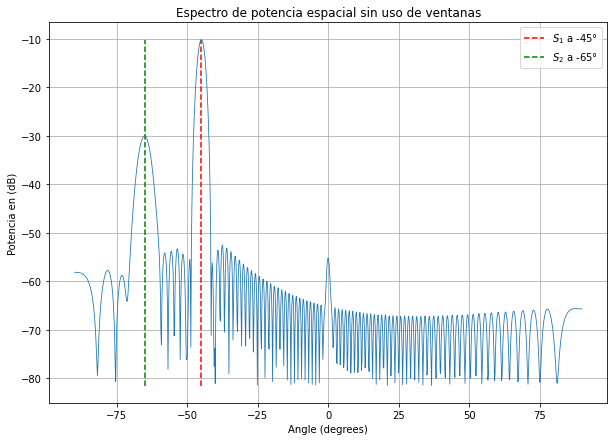

In [10]:
angles, power_at_angle_hamming = compute_spatial_spectrum(x_n, window=True)
spectral_power_db_hamming = 10*np.log10(power_at_angle_hamming / M);
plt.figure(figsize=(10,7))
plt.title("Espectro de potencia espacial sin uso de ventanas")
plt.plot(angles, spectral_power_db_hamming, linewidth=0.8);
plt.vlines(-45,np.min(spectral_power_db_hamming),np.max(spectral_power_db_hamming), color='red', linestyles="--", label="$S_1$ a -45°");
plt.vlines(-65,np.min(spectral_power_db_hamming),np.max(spectral_power_db_hamming), color='green',linestyles="--",label="$S_2$ a -65°");
plt.grid(which='both');
plt.ylabel("Potencia en (dB)")
plt.xlabel("Angle (degrees)")
plt.legend();

Notamos como el uso de ventanas reduce el leackage espectral a costas de perder resolución espectral

#Ej 4
 Para las señales del ejercicio anterior, con M = 16 y d = λ / 2, y asumiendo que $x_1(n)$ es
una señal de interés y $x_2(n)$ una interferencia, determinar el beamformer SMI óptimo y
estimar su loss SINR en función del ángulo φ.

Para poder calcular el beamformer optimo utilizaremos el metodo de **Sample Matrix Inversion**. Cabe destacar que tambien existen otras formas basadas en RLS y Steepest descent.

In [11]:
#Generamos las señales. Nota, las variables de este apartado tiene un "_4" para indicar que pertencen a este apartado

M_4 = 16 #Cantidad de sensores
d_4 = lambda_signals / 2 #espaciamiento entre sensores
N_4 = 10000

#Señal 1
sigma_2_1_4 = 1 
signal_1_4 = model_noise(1, N_4, sigma_2_1).flatten()

#Señal 2
sigma_2_2_4 = 0.1
signal_2_4 = model_noise(1, N_4, sigma_2_2).flatten()

#Generamos el ruido aditivo de los sensores
sigma_2_sensor_4 = 0.005
sensors_noise_4 = model_noise(M_4, N_4, sigma_2_sensor)

#Modelamos la recepción de las señales
v_m45_4 ,model_1_interes = model(M_4, d_4, signal_1_4, lambda_signals, -45)
v_m65_4 ,model_2_interferencia = model(M_4, d_4, signal_2_4, lambda_signals, -65)

#Modelamos las señales que se reciben en los sensores
x_n_4 = (model_1_interes + model_2_interferencia)*np.sqrt(M_4) + sensors_noise_4

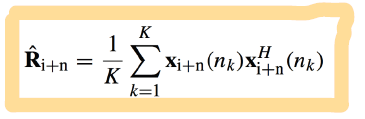

Como en este caso $x_2(n)$ es considerada la señal interferencia entonces armaremos una señal de silencio donde solo esten presentes $x_2(n)$ y el ruido propio del canal más el ruido termico de los sesores.

In [12]:
signal_silencio = model_2_interferencia*np.sqrt(M_4) + sensors_noise_4

Rin = np.zeros((M_4, M_4))

for n in range(N_4):
  n_column = [signal_silencio[:, n]]
  rin_n = np.matmul(np.transpose(n_column), np.conjugate(n_column))
  Rin = Rin + rin_n
  
Rin = Rin / N_4

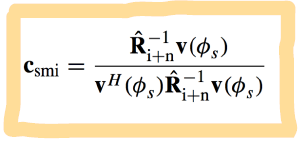

In [13]:
Rin_inv = np.linalg.inv(Rin)
v_phi_s = [generate_v(M_4, d_4, lambda_signals, -65)]
csmi_num = np.matmul(Rin_inv, np.transpose(v_phi_s))  
 
temp_den = np.matmul(np.conjugate(v_phi_s), Rin_inv)
csmi_den = np.matmul(temp_den, np.transpose(v_phi_s))
csmi = csmi_num / csmi_den

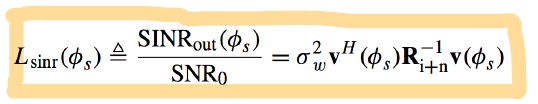

In [14]:
def compute_Lsinr(Rin, sigma_2_noise, d, lambda_c):
  angles = np.linspace(-90, 90, 1000)
  lsinr = []
  Rin_inv = np.linalg.inv(Rin*N_4/4)
  for angle in angles:
    v = np.array([generate_v(Rin.shape[0], d, lambda_c, angle)])
    temp_1 = np.matmul(np.conjugate(v), Rin_inv)
    temp_2 = np.matmul(temp_1, np.transpose(v)) 
    lsinr.append(sigma_2_noise*temp_2)
  return angles, np.array(lsinr)

In [15]:
angles, Lsinr = compute_Lsinr(Rin, sigma_2_sensor_4, d_4, lambda_signals)

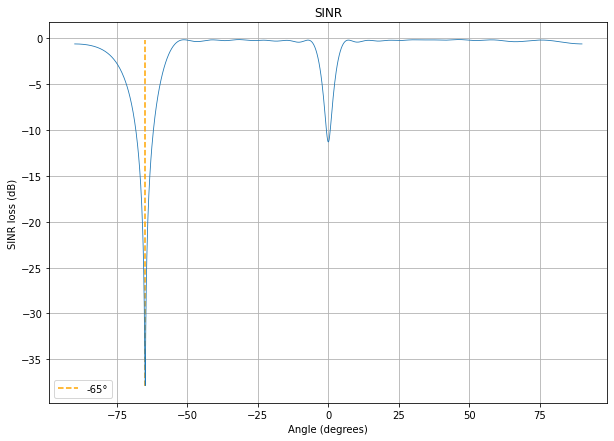

In [16]:
SINR_dB = 10*np.log10(np.abs(Lsinr.flatten()))
plt.figure(figsize=(10,7))
plt.title("SINR")
plt.plot(angles, SINR_dB, linewidth=0.8)
plt.ylabel("SINR loss (dB)")
plt.xlabel("Angle (degrees)")
plt.vlines(-65, np.min(SINR_dB), np.max(SINR_dB), color="orange", label="-65°", linestyles="--")
plt.grid(which='both');
plt.legend();